In [85]:
library("dplyr")
library("igraph")
library("bnstruct")

## Grapher function:

In [245]:
plot_BN <- function(papitos, labels=NULL){
    
    #Create an "edge list matrix" ---> https://igraph.org/r/doc/graph_from_edgelist.html
    
    outgoing <- c()
    incoming <- c()
    for(i in 1:length(papitos)){
        for(j in papitos[[i]]){
            outgoing <- c(outgoing, as.character(j))
            incoming <- c(incoming, as.character(i))
            
        }
    }
    edge_list_matrix <- t(rbind(outgoing, incoming)) #transpose    
    
    network <- graph_from_edgelist(edge_list_matrix, directed=TRUE)
    par(bg="beige")
    igraph::plot.igraph(network, 
                                layout=layout.fruchterman.reingold,
                                vertex.color = rgb(0.7,0.1,0.9),
                                vertex.label.font=5,
                                vertex.label.cex = 1.9,
                                vertex.frame.color = "white",                 
                                vertex.shape="square",                        
                                vertex.size=25,                               
                                vertex.label.color="white", 
                                edge.width=3,
                                edge.color='black',
                                edge.arrow.size=1,
                                edge.arrow.width=1,
                                edge.curved=0.25)
        title("Learned Bayesian Network", cex.main=2,col.main="black")
        legend("bottomright", labels)
}

## Algorithm: 

1. Set of nodes *Z*
2. Ordering of the nodes
3. Upper bound on the number of parents (for each node) *u*
4. Database *D* of m cases

In [249]:
N_tensor <- function(D, i, V.i, pi.i){
    result <- D %>% count(D[,pi.i], name='j_counts')
    if (length(pi.i) == 1){colnames(result)[1] <- 'j'}
        for (k in V.i){
            k_count <- D[D[, i]==k,] %>% count(D[D[, i]==k,pi.i])
            if (length(pi.i) == 1){colnames(k_count)[1] <- 'j'}
            colnames(k_count)[length(colnames(k_count))]<- k
            result <- merge(result, k_count, all.x=TRUE) 
        }
        result[is.na(result)] <- 0
    return(result)
}

g <- function(V.i, r.i, N.tensor){
    N.ij <- N.tensor$j_counts
    q.i <- length(N.ij) # number of unique combinations of the parents realizations
    result <- 1
    for (j in 1:q.i) {
        a <- 1
        for (k in V.i){a <- a*factorial(N.tensor[j,as.character(k)])}
        result <- result*a*factorial(r.i-1)/factorial(N.ij[j]+r.i-1)
    }
    return(result)
}


k2 <- function(Z, u, D){
    V <- unname(sapply(D, unique)) #it's a matrix or a list
    r <- unname(sapply(D, n_distinct)) #it's a vector
    parents <- list()
    for (i in 1:length(Z)){
        pi.i <- NULL 
        Nijk <- N_tensor(D, Z[i], V[,i], pi.i)
        P_old <- g(V[,i],r[i], Nijk)
        proceed <- TRUE
        changed <- FALSE
        while (proceed & (length(pi.i)<u & i>1)){
            pred.i <- setdiff(Z[1:i-1], pi.i)
            P <- 0
            for (node in pred.i){
                new_set <- union(pi.i, node)
                Nijk <- N_tensor(D, Z[i], V[,i], new_set)
                P <- g(V[,i], r[i], Nijk)
                cat('\n P:', P)
                cat('\n P_old:', P_old)
                if (P > P_old){
                    P_old <- P
                    temp.pi <- new_set
                    changed <- TRUE
                }
            }
            if (changed != TRUE){
                proceed <- FALSE
            } else{
                pi.i <- temp.pi
                changed <- FALSE
            }
        }
        parents <- append(parents, list(pi.i))
    } 
    return(parents)
}


## Test on dummy dataset:

### 3 nodes test:

In [250]:
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3<- c(0,1,1,1,0,1,1,0,1,0)

toy.3nodes <- data.frame(x1, x2, x3)

print(D)

   x1 x2 x3
1   1  0  0
2   1  1  1
3   0  0  1
4   1  1  1
5   0  0  0
6   0  1  1
7   1  1  1
8   0  0  0
9   1  1  1
10  0  0  0



 P: 0.001111111
 P_old: 0.0003607504
 P: 0.0005555556
 P_old: 0.0004329004
 P: 0.005555556
 P_old: 0.0005555556
 P: 0.0025
 P_old: 0.005555556

ERROR: Error in as.graphicsAnnot(legend): argomento "legend" assente, senza valore predefinito


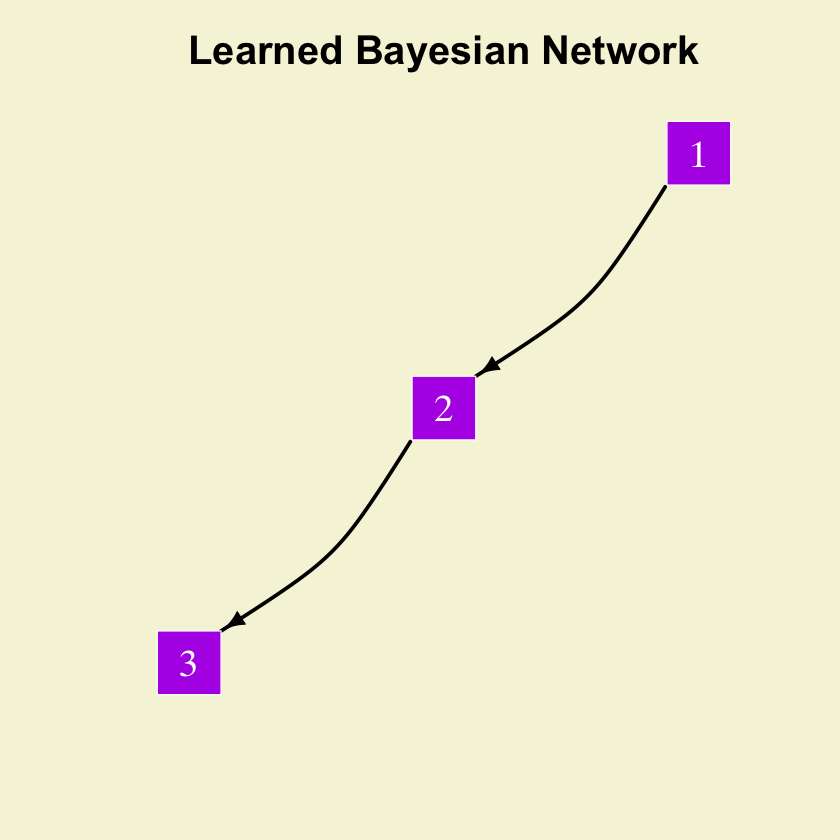

In [251]:
parents <- k2(c(1,2,3), u=3, toy.3nodes)
plot_BN(parents)

### Comparison with Bnstruct

In [254]:
k2_bnstruct <- function(data, u, bootstrap = FALSE){
    net <- learn.network(data, bootstrap)
    return (net)
}
k2_bnstruct(toy.3nodes,3)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘learn.network’ for signature ‘"data.frame"’


### 15 nodes test:

In [111]:
m=100
L=15
data<- sample(0:1,replace=TRUE, size=m*L)
dim(data)<-c(m,L)
toy.15nodes <- data.frame(data)

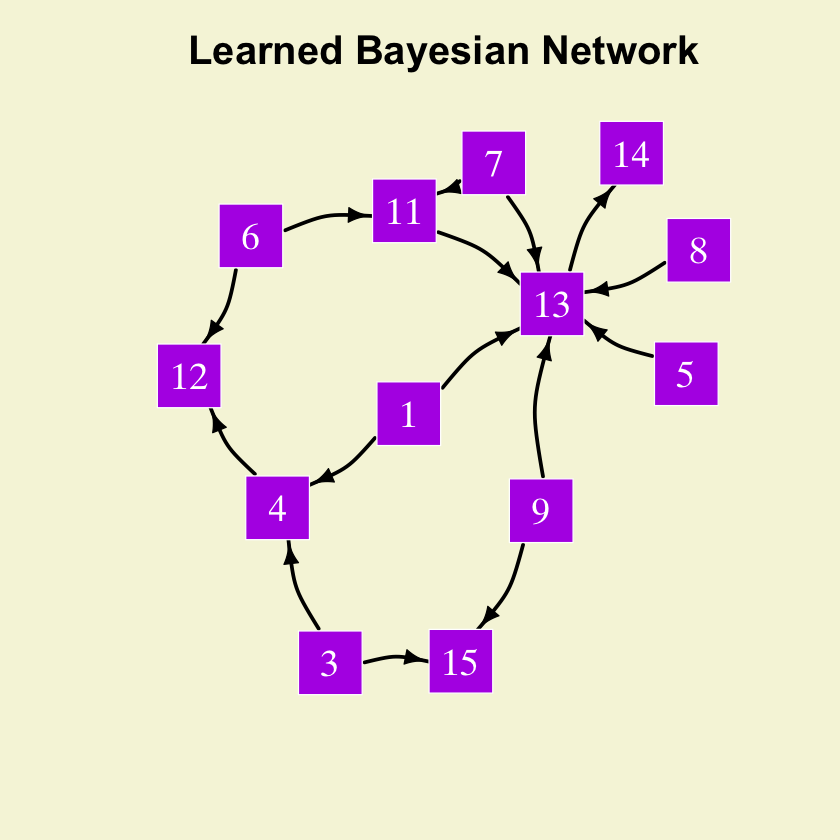

In [113]:
parents <- k2(1:L, u=10, toy.15nodes)
plot_BN(parents)

### Algorithm with log imlementation

In [216]:
log_factorial <- function(N){
    if(N > 15){return(N*log(N)-N)}
    else if(N==0){return(0)}
    else{return(log(factorial(N)))}
}


g_log <- function(V.i, r.i, N.tensor){
    N.ij <- N.tensor$j_counts
    q.i <- length(N.ij) # number of unique combinations of the parents realizations
    result <- 0
    for (j in 1:q.i) {
        a <- 0
        for (k in V.i){a <- a+log_factorial(N.tensor[j,as.character(k)])}
        result <- result+a+log_factorial(r.i-1)-log_factorial(N.ij[j]+r.i-1)
    }
    return(result)
}

k2_log <- function(Z, u, D){
    V <- unname(sapply(D, unique)) #it's a matrix or a list
    r <- unname(sapply(D, n_distinct)) #it's a vector
    parents <- list()
    for (i in 1:length(Z)){
        pi.i <- NULL 
        Nijk <- N_tensor(D, Z[i], V[[i]], pi.i)
        P_old <- g_log(V[[i]],r[i], Nijk)
        proceed <- TRUE
        changed <- FALSE
        while (proceed & (length(pi.i)<u & i>1)){
            pred.i <- setdiff(Z[1:i-1], pi.i)
            P <- 0
            for (node in pred.i){
                new_set <- union(pi.i, node)
                Nijk <- N_tensor(D, Z[i], V[[i]], new_set)
                P <- g_log(V[[i]], r[i], Nijk)
                if (P > P_old){
                    P_old <- P
                    temp.pi <- new_set
                    changed <- TRUE
                }
            }
            if (changed != TRUE){
                proceed <- FALSE
            } else{
                pi.i <- temp.pi
                changed <- FALSE
            }
        }
        parents <- append(parents, list(pi.i))
    } 
    return(parents)
}




## Testing on an actual Dataset:


   Attribute   Domain
   - Clump Thickness               1 - 10
   - Uniformity of Cell Size       1 - 10
   - Uniformity of Cell Shape      1 - 10
   - Marginal Adhesion             1 - 10
   - Single Epithelial Cell Size   1 - 10
   - Bare Nuclei                   1 - 10
   - Bland Chromatin               1 - 10
   - Normal Nucleoli               1 - 10
   - Mitoses                       1 - 10
   - Class:                        (2 for benign, 4 for malignant)

In [234]:
bc.labels <- c('1: Clump Thickness','2: Uniformity of Cell Size','3: Uniformity of Cell Shape','4: Marginal Adhesion','5: Single Epithelial Cell Size','6: Bare Nuclei','7:Bland Chromatin','8:Normal Nucleoli','9: Mitoses','10: Class')

In [217]:
data<-read.csv("breast-cancer.txt")[,-1]
breast_cancer_df<-data[data$Bare_Nuclei %in% 1:10, ]
breast_cancer_df<-transform(breast_cancer_df, Bare_Nuclei = as.integer(Bare_Nuclei))
head(breast_cancer_df)

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,5,1,1,1,2,1,3,1,1,2
2,5,4,4,5,7,10,3,2,1,2
3,3,1,1,1,2,2,3,1,1,2
4,6,8,8,1,3,4,3,7,1,2
5,4,1,1,3,2,1,3,1,1,2
6,8,10,10,8,7,10,9,7,1,4


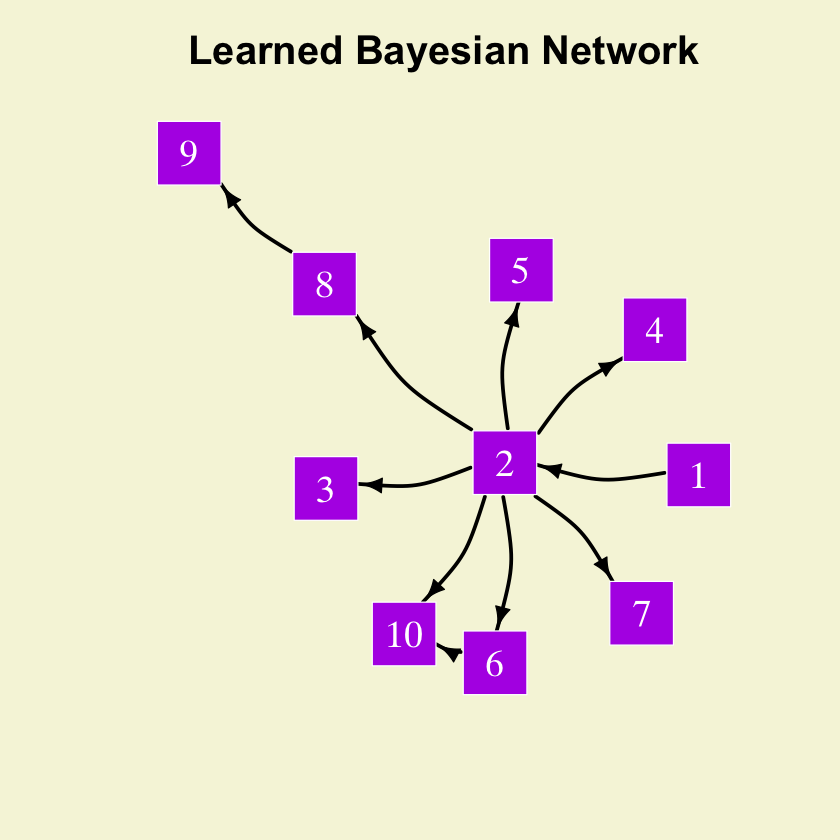

In [222]:
parents <- k2_log(1:length(breast_cancer_df), u=10, breast_cancer_df)

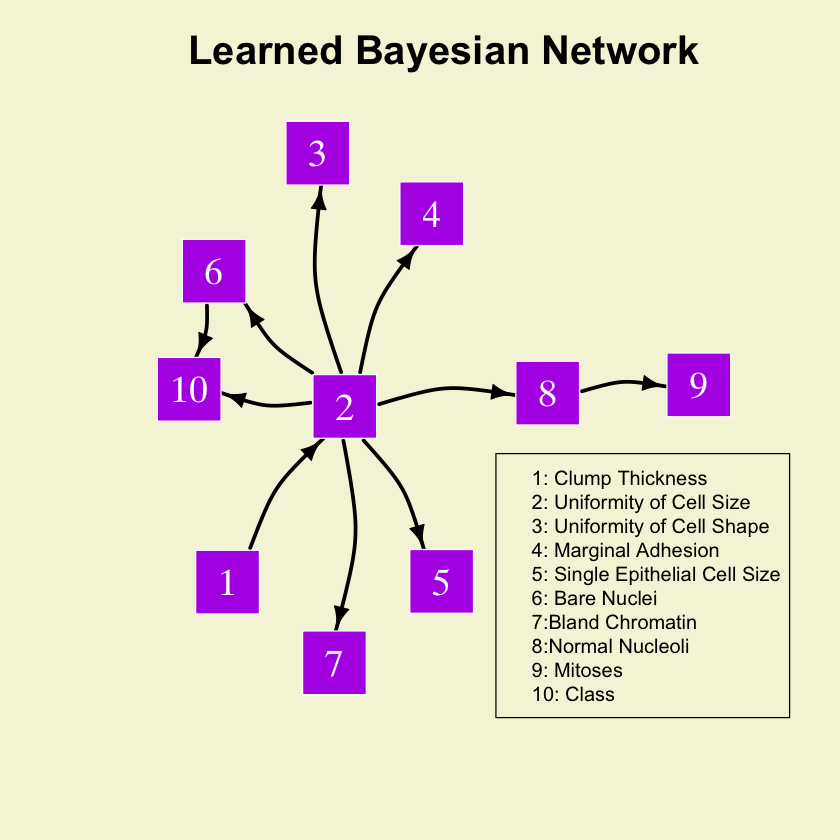

In [242]:
plot_BN(parents, bc.labels)